In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys

EXP_NAME = "autoencoder-space-granularity-analisys"
PROJECT_ROOT = "/home/jovyan/vmeshchaninov/LatentDiffusion"
EXP_RESULT_PATH = f"{PROJECT_ROOT}/experiments/results/{EXP_NAME}/"
os.makedirs(EXP_RESULT_PATH, exist_ok=True)
sys.path.append(PROJECT_ROOT)
os.environ["PROJECT_ROOT"] = PROJECT_ROOT

In [4]:
import torch
import hydra
from omegaconf import DictConfig, OmegaConf
from hydra.core.global_hydra import GlobalHydra

from encoder_trainer import EncoderTrainer

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import rel_entr  # KL divergence computation

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reset Hydra to avoid conflicts if already initialized
GlobalHydra.instance().clear()

# Initialize Hydra and load config manually
hydra.initialize(config_path="../conf", version_base=None)  # Set path to your configs

# Load the configuration
cfg = hydra.compose(config_name="config")  # Replace with your main config file

/home/jovyan/.mlspace/envs/dif_env/lib/python3.11/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [28]:
# Setup the config
cfg.ddp.enabled = False
cfg.autoencoder.model.load_checkpoint = "autoencoder-num_latents=16-wikipedia-v2.3.4-128/100000.pth"

trainer_wiki_16 = EncoderTrainer(cfg)


Checkpotint autoencoder-num_latents=16-wikipedia-v2.3.4-128/100000.pth loaded


In [29]:
trainer_wiki_16.encoder.eval()
trainer_wiki_16.decoder.eval()
print()

In [7]:
# Setup the config
cfg.ddp.enabled = False
cfg.autoencoder.latent.resolutions = [16]
cfg.encoder.embedding.max_position_embeddings = 80
cfg.decoder.embedding.max_position_embeddings = 80
cfg.autoencoder.model.load_checkpoint = "autoencoder-latent_dim=768-latent_resolutions=[16]-bert_model=bert-base-cased-level_weights=[1.0, 1.0, 1.0, 1.0]-bert_masking_enc=False-bert_masking_dec=False-mlm_probabilities_dec=[1.0]-optimizer=lion/20000.pth"

trainer_roc_16 = EncoderTrainer(cfg)


/home/jovyan/.mlspace/envs/dif_env_v2/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Checkpotint autoencoder-latent_dim=768-latent_resolutions=[16]-bert_model=bert-base-cased-level_weights=[1.0, 1.0, 1.0, 1.0]-bert_masking_enc=False-bert_masking_dec=False-mlm_probabilities_dec=[1.0]-optimizer=lion/20000.pth loaded
Checkpotint autoencoder-latent_dim=768-latent_resolutions=[16]-bert_model=bert-base-cased-level_weights=[1.0, 1.0, 1.0, 1.0]-bert_masking_enc=False-bert_masking_dec=False-mlm_probabilities_dec=[1.0]-optimizer=lion/20000.pth loaded


In [8]:
trainer_roc_16.encoder.eval()
trainer_roc_16.decoder.eval()
print()

In [9]:
from datasets import Dataset, load_from_disk

In [10]:
path_to_data = f"{PROJECT_ROOT}/data/rocstories"
data = load_from_disk(path_to_data)

In [11]:
selected_data = data["train"].shuffle(seed=42).select(range(10000))
selected_data = selected_data["text_trg"]


In [12]:
def get_latent(text, trainer):
    tokenized = trainer.tokenizer(
        text,
        add_special_tokens=True,
        padding=True,
        truncation=True,
        max_length=trainer.cfg.decoder.embedding.max_position_embeddings,
        return_tensors="pt",
        return_attention_mask=True,
        return_token_type_ids=False,
    ).to(device)

    print(tokenized["input_ids"].shape)

    with torch.autocast(device_type='cuda', dtype=torch.bfloat16), torch.no_grad():
        latents = trainer.encoder(token_ids=tokenized["input_ids"], mask_tokens=tokenized["attention_mask"])
    return latents


In [13]:
latents_wiki_16 = get_latent(selected_data, trainer_wiki_16)

torch.Size([10000, 80])


/home/jovyan/.mlspace/envs/dif_env_v2/lib/python3.11/contextlib.py:105: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


In [14]:
latents_roc_16 = get_latent(selected_data, trainer_roc_16)

torch.Size([10000, 80])


## Pairwise distances

In [15]:
from tqdm import tqdm

@torch.no_grad()
def calculate_pairwise_distances(latents):
    batch_size = 100
    num_samples = latents.shape[0]
    pairwise_distances = torch.zeros((num_samples, num_samples), device=device)

    for i in tqdm(range(0, num_samples, batch_size)):
        batch_i = latents[i:i+batch_size].reshape(batch_size, -1)
        for j in range(0, num_samples, batch_size):
            batch_j = latents[j:j+batch_size].reshape(batch_size, -1)
            
            dist = torch.cdist(batch_i, batch_j)
            pairwise_distances[i:i+batch_size, j:j+batch_size] = dist

    return pairwise_distances

In [22]:
distance_wiki_16 = calculate_pairwise_distances(latents_wiki_16)
distance_roc_16 = calculate_pairwise_distances(latents_roc_16)

In [35]:
distance_wiki_16.shape

In [36]:
distance_wiki_16.mean(), distance_roc_16.mean()

In [41]:
import matplotlib.pyplot as plt

# Convert tensors to numpy arrays and flatten
mask = np.triu(np.ones_like(distance_wiki_16.cpu().numpy()), k=1).astype(bool)
wiki_distances = distance_wiki_16.cpu().numpy()[mask]
roc_distances = distance_roc_16.cpu().numpy()[mask]

plt.figure(figsize=(12, 6))

# Plot histograms
plt.hist(wiki_distances, bins=100, alpha=0.5, label='Wiki-16', density=True)
plt.hist(roc_distances, bins=100, alpha=0.5, label='RocStories-16', density=True)

plt.xlabel('Pairwise Distances')
plt.ylabel('Density')
plt.title('Distribution of Pairwise Distances in Latent Space')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()


### Distance to the nearest neighbor

In [ ]:
diag = torch.eye(distance_wiki_16.shape[0], device=device) * 1e6
distances_to_nearest_neighbor_wiki_16 = (distance_wiki_16 + diag).min(dim=1)[0]
distances_to_nearest_neighbor_roc_16 = (distance_roc_16 + diag).min(dim=1)[0]

plt.figure(figsize=(12, 6))

plt.hist(distances_to_nearest_neighbor_wiki_16.cpu().numpy(), bins=100, alpha=0.5, label='Wiki-16', density=True)
plt.hist(distances_to_nearest_neighbor_roc_16.cpu().numpy(), bins=100, alpha=0.5, label='RocStories-16', density=True)

plt.xlabel('Distance to the nearest neighbor')
plt.ylabel('Density')
plt.title('Distribution of Distance to the Nearest Neighbor in Latent Space')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [17]:
e1 = torch.randn(1000, latents_wiki_16.shape[1] * latents_wiki_16.shape[2], device=device)
e2 = torch.randn(1000, latents_wiki_16.shape[1] * latents_wiki_16.shape[2], device=device)

dist = torch.cdist(e1, e2)

dist.mean()


In [18]:
latents_wiki_16.shape

In [21]:
(16 * 768) ** 0.5 * (2 ** 0.5)

In [23]:
pairwise_distances_std_wiki_16 = torch.sort(distance_wiki_16, dim=1)[0][:, 1:].std(dim=1)
pairwise_distances_std_roc_16 = torch.sort(distance_roc_16, dim=1)[0][:, 1:].std(dim=1)

plt.figure(figsize=(12, 6))

plt.hist(pairwise_distances_std_wiki_16.cpu().numpy(), bins=100, alpha=0.5, label='Wiki-16', density=True)
plt.hist(pairwise_distances_std_roc_16.cpu().numpy(), bins=100, alpha=0.5, label='RocStories-16', density=True)

plt.xlabel('Pairwise Distances Standard Deviation')
plt.ylabel('Density')
plt.title('Distribution of Pairwise Distances Standard Deviation in Latent Space')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()






## DCT of embeddings

In [24]:
import numpy as np
from scipy.fft import dct

def compute_dct(embedding: np.ndarray) -> np.ndarray:
    """
    Compute the Discrete Cosine Transform (DCT) of a text embedding vector.
    
    Parameters:
        embedding (np.ndarray): A 2D numpy array representing the text embedding of size NxD.
    
    Returns:
        np.ndarray: The DCT coefficients of the input embedding.
    """
    # Using DCT type-II with orthogonal normalization (common in compression applications)
    return dct(embedding, type=2, norm='ortho', axis=1)

In [53]:
d = 128 * 2
dct_wiki_16 = compute_dct(latents_wiki_16.cpu().numpy().reshape(-1, d))
dct_roc_16 = compute_dct(latents_roc_16.cpu().numpy().reshape(-1, d))

In [54]:
amplitudes_wiki_16 = np.abs(dct_wiki_16 / dct_wiki_16[:, :1]).mean(axis=0)
amplitudes_roc_16 = np.abs(dct_roc_16 / dct_roc_16[:, :1]).mean(axis=0)

In [55]:
plt.figure(figsize=(12 * 2, 6))
plt.plot(amplitudes_wiki_16, color='blue', alpha=0.8, linewidth=2, label='Wiki-16')
plt.plot(amplitudes_roc_16, color='red', alpha=0.8, linewidth=2, label='RocStories-16')
# plt.fill_between(range(len(amlitides_wiki_16)), amlitides_wiki_16, alpha=0.2, color='blue')
plt.xlabel('DCT Coefficient Index')
plt.ylabel('Mean Normalized Amplitude')
plt.title('DCT Coefficient Analysis of Wiki-16 Embeddings', pad=20)
plt.grid(True, alpha=0.3, linestyle='--')
plt.yscale('log')  # Using log scale to better visualize the amplitude decay
plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.5, label='Baseline')

plt.legend()
plt.show()

## Smothness of the latent space

In [14]:
from tqdm import tqdm

def get_tokens_from_latent(latent, trainer):
    batch_size = 1000
    num_samples = latent.shape[0]
    tokens = torch.zeros((num_samples, trainer.decoder.max_position_embeddings), device=device)

    for i in range(0, num_samples, batch_size):
        batch_i = latent[i:i+batch_size]
        with torch.autocast(device_type='cuda', dtype=torch.bfloat16), torch.no_grad():
            logits = trainer.decoder(batch_i)
        tokens[i:i+batch_size] = torch.argmax(logits, dim=2)
    return tokens

In [15]:
def masked_accuracy(tokens, tokenized_X):
    mask = tokenized_X["attention_mask"].bool()
    return (tokens[mask] == tokenized_X["input_ids"][mask]).float().mean()

### Latent perturbation via noise

In [13]:
sigma = 0.
latents_wiki_16_perturbed = latents_wiki_16 + torch.randn_like(latents_wiki_16) * sigma
latents_roc_16_perturbed = latents_roc_16 + torch.randn_like(latents_roc_16) * sigma

In [29]:
tokens_wiki_16_perturbed = get_tokens_from_latent(latents_wiki_16_perturbed, trainer_wiki_16)[:, :80]
tokens_roc_16_perturbed = get_tokens_from_latent(latents_roc_16_perturbed, trainer_roc_16)

In [30]:
tokenized_X = trainer_roc_16.tokenizer(selected_data, return_tensors="pt", padding=True, truncation=True, max_length=trainer_roc_16.decoder.max_position_embeddings).to(device)

In [33]:
masked_accuracy(tokens_wiki_16_perturbed, tokenized_X), masked_accuracy(tokens_roc_16_perturbed, tokenized_X)

In [38]:
accuracy_dict = {
    "roc": [],
    "wiki": []
}
for sigma in tqdm(np.linspace(0., 1., 10)):
    latents_wiki_16_perturbed = latents_wiki_16 + torch.randn_like(latents_wiki_16) * sigma
    latents_roc_16_perturbed = latents_roc_16 + torch.randn_like(latents_roc_16) * sigma
    tokens_wiki_16_perturbed = get_tokens_from_latent(latents_wiki_16_perturbed, trainer_wiki_16)[:, :80]
    tokens_roc_16_perturbed = get_tokens_from_latent(latents_roc_16_perturbed, trainer_roc_16)
    accuracy_dict["roc"].append(masked_accuracy(tokens_roc_16_perturbed, tokenized_X).item())
    accuracy_dict["wiki"].append(masked_accuracy(tokens_wiki_16_perturbed, tokenized_X).item())

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0., 1., 10), accuracy_dict["roc"], color='red', alpha=0.8, linewidth=2, label='RocStories-16')
plt.plot(np.linspace(0., 1., 10), accuracy_dict["wiki"], color='blue', alpha=0.8, linewidth=2, label='Wiki-16')
plt.xlabel('Noise Level')
plt.ylabel('Accuracy')
plt.title('Accuracy of Token Prediction with Different Noise Levels')
plt.legend()
plt.show()

### Latent perturbation via interpolation

In [16]:
distance_wiki_16 = calculate_pairwise_distances(latents_wiki_16)
distance_roc_16 = calculate_pairwise_distances(latents_roc_16)

In [20]:
latents_wiki_16[perm_indices_wiki].shape

In [21]:
sigma = 0.5
# Randomly permute indices to get different latent pairs
perm_indices_wiki = torch.sort(distance_wiki_16, dim=1)[1][:, 1]
perm_indices_roc = torch.sort(distance_roc_16, dim=1)[1][:, 1]

# Select permuted latents 
latents_wiki_16_other = latents_wiki_16[perm_indices_wiki]
latents_roc_16_other = latents_roc_16[perm_indices_roc]

In [22]:
tokens_wiki_16_perturbed = get_tokens_from_latent(latents_wiki_16_perturbed, trainer_wiki_16)[:, :80]
tokens_roc_16_perturbed = get_tokens_from_latent(latents_roc_16_perturbed, trainer_roc_16)

In [23]:
tokenized_X = trainer_roc_16.tokenizer(selected_data, return_tensors="pt", padding=True, truncation=True, max_length=trainer_roc_16.decoder.max_position_embeddings).to(device)

In [24]:
masked_accuracy(tokens_wiki_16_perturbed, tokenized_X), masked_accuracy(tokens_roc_16_perturbed, tokenized_X)

In [25]:
accuracy_dict = {
    "roc": [],
    "wiki": []
}

for sigma in tqdm(np.linspace(0., 1., 20)):
    latents_wiki_16_perturbed = latents_wiki_16 * (1 - sigma) + latents_wiki_16_other * sigma
    latents_roc_16_perturbed = latents_roc_16 * (1 - sigma) + latents_roc_16_other * sigma
    tokens_wiki_16_perturbed = get_tokens_from_latent(latents_wiki_16_perturbed, trainer_wiki_16)[:, :80]
    tokens_roc_16_perturbed = get_tokens_from_latent(latents_roc_16_perturbed, trainer_roc_16)
    accuracy_dict["roc"].append(masked_accuracy(tokens_roc_16_perturbed, tokenized_X).item())
    accuracy_dict["wiki"].append(masked_accuracy(tokens_wiki_16_perturbed, tokenized_X).item())

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0., 1., 20), accuracy_dict["roc"], color='red', alpha=0.8, linewidth=2, label='RocStories-16')
plt.plot(np.linspace(0., 1., 20), accuracy_dict["wiki"], color='blue', alpha=0.8, linewidth=2, label='Wiki-16')
plt.ylim(0., 1.0)
plt.xlabel('Interpolation Level')
plt.ylabel('Accuracy')
plt.title('Accuracy of Token Prediction with Different Interpolation Levels. Interpolation between two nearest latent vectors')
plt.legend()
plt.show()

In [29]:
sigma = 1.
latents_wiki_16_perturbed = latents_wiki_16 * (1 - sigma) + latents_wiki_16_other * sigma
latents_roc_16_perturbed = latents_roc_16 * (1 - sigma) + latents_roc_16_other * sigma

In [30]:
tokens_wiki_16_perturbed = get_tokens_from_latent(latents_wiki_16_perturbed, trainer_wiki_16)[:, :80]
tokens_roc_16_perturbed = get_tokens_from_latent(latents_roc_16_perturbed, trainer_roc_16)

In [37]:
def get_equal_tokens(tokens, tokenized_X):
    mask = tokenized_X["attention_mask"].bool()
    equal_tokens = (tokens[mask] == tokenized_X["input_ids"][mask])
    return tokenized_X["input_ids"][mask][equal_tokens]

In [42]:
equal_tokens_wiki_16 = get_equal_tokens(tokens_wiki_16_perturbed, tokenized_X)
equal_tokens_wiki_16 = equal_tokens_wiki_16.cpu().numpy()
equal_tokens_roc_16 = get_equal_tokens(tokens_roc_16_perturbed, tokenized_X)
equal_tokens_roc_16 = equal_tokens_roc_16.cpu().numpy()

In [44]:
len(equal_tokens_wiki_16), len(equal_tokens_roc_16)

In [52]:
len(set(equal_tokens_wiki_16)), len(set(equal_tokens_roc_16))

In [53]:
len(set(equal_tokens_wiki_16) - set(equal_tokens_roc_16)) , len(set(equal_tokens_roc_16) - set(equal_tokens_wiki_16))


In [64]:
import pandas as pd
from collections import Counter

df_wiki = pd.DataFrame.from_dict(Counter(equal_tokens_wiki_16), orient='index', columns=['wiki_count'])
df_roc = pd.DataFrame.from_dict(Counter(equal_tokens_roc_16), orient='index', columns=['roc_count'])
df_wiki['word'] = [trainer_wiki_16.tokenizer.decode(t) for t in df_wiki.index]
df = df_wiki.join(df_roc, how='outer').fillna(0)
df = df[['word', 'wiki_count', 'roc_count']]
df.sort_values(by='wiki_count', ascending=False, inplace=True)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
df.head(30).transpose()

## Text Perturbation

In [109]:
from tqdm import tqdm

def get_perturbed_latent(input_ids, attention_mask, trainer):
    with torch.autocast(device_type='cuda', dtype=torch.bfloat16), torch.no_grad():
        latents = trainer.encoder(token_ids=input_ids, mask_tokens=attention_mask)
    return latents

In [110]:
tokenized = trainer_roc_16.tokenizer(
        selected_data,
        add_special_tokens=True,
        padding=True,
        truncation=True,
        max_length=trainer_roc_16.cfg.decoder.embedding.max_position_embeddings,
        return_tensors="pt",
        return_attention_mask=True,
        return_token_type_ids=False,
    ).to(device)


In [111]:
from tqdm import tqdm

def get_logits_from_latent(latent, trainer):
    batch_size = 100
    num_samples = latent.shape[0]
    total_logits = torch.zeros((num_samples, trainer.decoder.max_position_embeddings, trainer.decoder.vocab_size), device="cpu")

    for i in range(0, num_samples, batch_size):
        batch_i = latent[i:i+batch_size]
        with torch.autocast(device_type='cuda', dtype=torch.bfloat16), torch.no_grad():
            logits = trainer.decoder(batch_i)
        total_logits[i:i+batch_size] = logits.cpu()
    return total_logits

In [112]:
prior_probability = torch.zeros(len(trainer_roc_16.tokenizer))

# Count occurrences of each token
for token in tqdm(tokenized["input_ids"].flatten()):
    prior_probability[token] += 1

for sp_token in trainer_roc_16.tokenizer.all_special_ids:
    prior_probability[sp_token] = 0.

prior_probability = prior_probability / prior_probability.sum()

  0%|          | 0/800000 [00:00<?, ?it/s]

 22%|██▏       | 179148/800000 [00:07<00:27, 22800.03it/s]


KeyboardInterrupt: 

In [17]:
def substitute_tokens(tokenized, token_probability, p=0.3):
    attention_mask = tokenized["attention_mask"]
    attention_mask = attention_mask.clone().bool()
    
    # Make mask
    probability_matrix = torch.full(tokenized["input_ids"].shape, p)
    probability_matrix[~attention_mask] = 0. # no mask for padding tokens 

    # Sample mask positions
    masked_positions = torch.bernoulli(probability_matrix).bool()

    if masked_positions.sum() == 0:
        return tokenized["input_ids"]

    # Sample random tokens according to token probability distribution
    random_tokens = torch.multinomial(token_probability, masked_positions.sum(), replacement=True)
    
    # Create perturbed input_ids by copying original
    perturbed_input_ids = tokenized["input_ids"].clone()
    
    # Replace tokens at masked positions with sampled tokens
    perturbed_input_ids[masked_positions] = random_tokens.cuda()
    
    return perturbed_input_ids

In [51]:
mse_dict = {
    "roc": [],
    "wiki": []
}
kldiv_dict = {
    "roc": [],
    "wiki": []
}

num_samples = 10

with torch.no_grad():
    latent_roc_16 = get_perturbed_latent(tokenized["input_ids"][:num_samples], tokenized["attention_mask"][:num_samples], trainer_roc_16)
    probs_roc_16 = torch.log(torch.softmax(get_logits_from_latent(latent_roc_16, trainer_roc_16), dim=2))
    latent_wiki_16 = get_perturbed_latent(tokenized["input_ids"][:num_samples], tokenized["attention_mask"][:num_samples], trainer_wiki_16)
    probs_wiki_16 = torch.log(torch.softmax(get_logits_from_latent(latent_wiki_16, trainer_wiki_16), dim=2))

    for p in tqdm(np.linspace(0., 1., 20)):
        perturbed_input_ids = substitute_tokens(tokenized, prior_probability, p=p)

        latent_roc_16_perturbed = get_perturbed_latent(perturbed_input_ids[:num_samples], tokenized["attention_mask"][:num_samples], trainer_roc_16)
        mse_dict["roc"].append(torch.norm(latent_roc_16 - latent_roc_16_perturbed, dim=[1,2]).mean().item())
        
        probs_roc_16_perturbed = torch.log(torch.softmax(get_logits_from_latent(latent_roc_16_perturbed, trainer_roc_16), dim=2))
        kldiv_loss = torch.nn.functional.kl_div(probs_roc_16, probs_roc_16_perturbed, reduction='batchmean', log_target=True)
        kldiv_dict["roc"].append(kldiv_loss.item())

        latent_wiki_16_perturbed = get_perturbed_latent(perturbed_input_ids[:num_samples], tokenized["attention_mask"][:num_samples], trainer_wiki_16)
        mse_dict["wiki"].append(torch.norm(latent_wiki_16 - latent_wiki_16_perturbed, dim=[1,2]).mean().item())
        
        probs_wiki_16_perturbed = torch.log(torch.softmax(get_logits_from_latent(latent_wiki_16_perturbed, trainer_wiki_16), dim=2))
        kldiv_loss = torch.nn.functional.kl_div(probs_wiki_16, probs_wiki_16_perturbed, reduction='batchmean', log_target=True)
        kldiv_dict["wiki"].append(kldiv_loss.item())



/home/jovyan/.mlspace/envs/dif_env_v2/lib/python3.11/contextlib.py:105: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)
100%|██████████| 20/20 [00:16<00:00,  1.18it/s]


In [45]:
latent_wiki_16 = get_perturbed_latent(tokenized["input_ids"][:num_samples], tokenized["attention_mask"][:num_samples], trainer_wiki_16)
probs_wiki_16 =   get_logits_from_latent(latent_wiki_16, trainer_wiki_16)
probs_wiki_16_2 = get_logits_from_latent(latent_wiki_16, trainer_wiki_16)

ce_loss = torch.nn.functional.kl_div(probs_wiki_16, probs_wiki_16_2, reduction='batchmean', log_target=True)
ce_loss


/home/jovyan/.mlspace/envs/dif_env_v2/lib/python3.11/contextlib.py:105: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


tensor(0.)

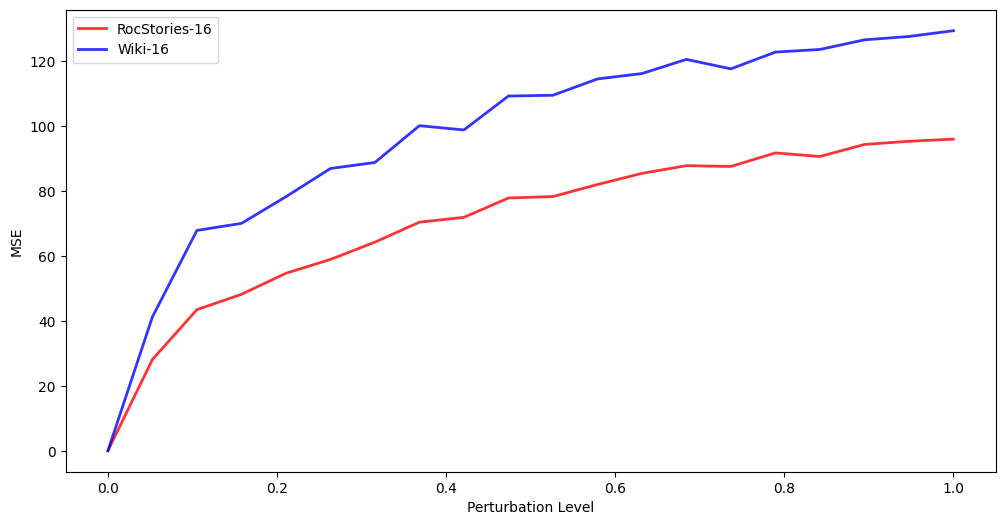

In [47]:
plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0., 1., 20), mse_dict["roc"], color='red', alpha=0.8, linewidth=2, label='RocStories-16')
plt.plot(np.linspace(0., 1., 20), mse_dict["wiki"], color='blue', alpha=0.8, linewidth=2, label='Wiki-16')
plt.xlabel('Perturbation Level')
plt.ylabel('MSE')
plt.legend()
plt.show()

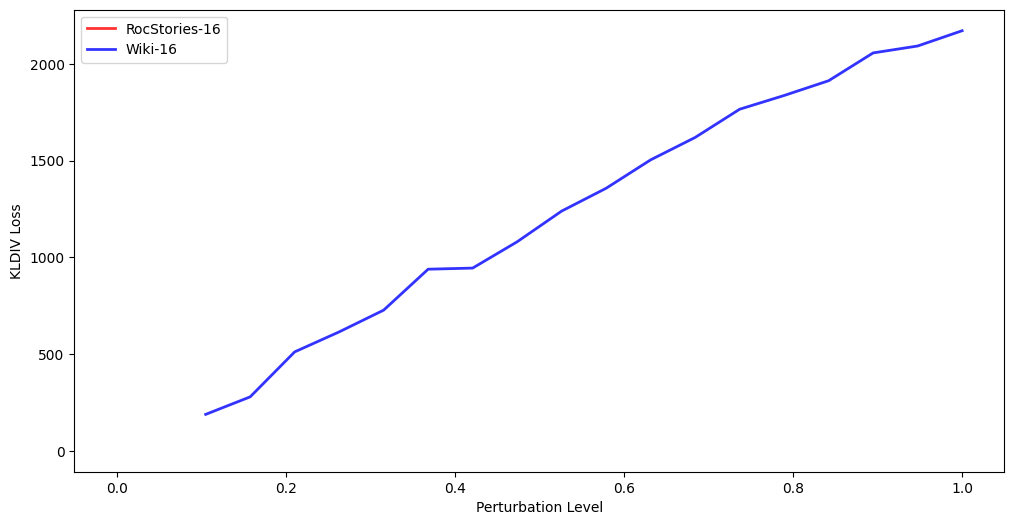

In [52]:
plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0., 1., 20), kldiv_dict["roc"], color='red', alpha=0.8, linewidth=2, label='RocStories-16')
plt.plot(np.linspace(0., 1., 20), kldiv_dict["wiki"], color='blue', alpha=0.8, linewidth=2, label='Wiki-16')
plt.xlabel('Perturbation Level')
plt.ylabel('KLDIV Loss')
plt.legend()
plt.show()

# PCA Comparison

In [20]:
from sklearn.decomposition import PCA

In [21]:
from transformers import AutoTokenizer
from transformers import AutoModel

In [22]:
n_components = 768

In [23]:
bert_model = AutoModel.from_pretrained("bert-base-cased").cuda()
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

/home/jovyan/.mlspace/envs/dif_env_v2/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [24]:
tokenized = tokenizer(
    selected_data,
    add_special_tokens=True,
    padding=True,
    truncation=True,
    max_length=80,
    return_tensors="pt",
    return_attention_mask=True,
    return_token_type_ids=False,
).to(device)

with torch.autocast(device_type='cuda', dtype=torch.bfloat16), torch.no_grad():
    bert_output = bert_model(tokenized["input_ids"], tokenized["attention_mask"]).last_hidden_state

bert_latent = bert_output[tokenized["attention_mask"].bool()].cpu().numpy()

In [36]:
pca = PCA(n_components=n_components)
pca.fit(bert_latent)

explained_variance = np.array(pca.explained_variance_ratio_)
sorted_variance = np.sort(explained_variance)[::-1]  # Sort in descending order
bert_cumulative_variance = np.cumsum(sorted_variance)

In [50]:
pca = PCA(n_components=n_components, svd_solver = 'full')
pca.fit(latents_wiki_16.reshape(-1, n_components).cpu().numpy())

explained_variance = np.array(pca.explained_variance_ratio_)
sorted_variance = np.sort(explained_variance)[::-1]  # Sort in descending order
wiki_cumulative_variance = np.cumsum(sorted_variance)

In [48]:
pca = PCA(n_components=n_components, svd_solver = 'full')
pca.fit(latents_roc_16.reshape(-1, n_components).cpu().numpy())

explained_variance = np.array(pca.explained_variance_ratio_)
sorted_variance = np.sort(explained_variance)[::-1]  # Sort in descending order
roc_cumulative_variance = np.cumsum(sorted_variance)

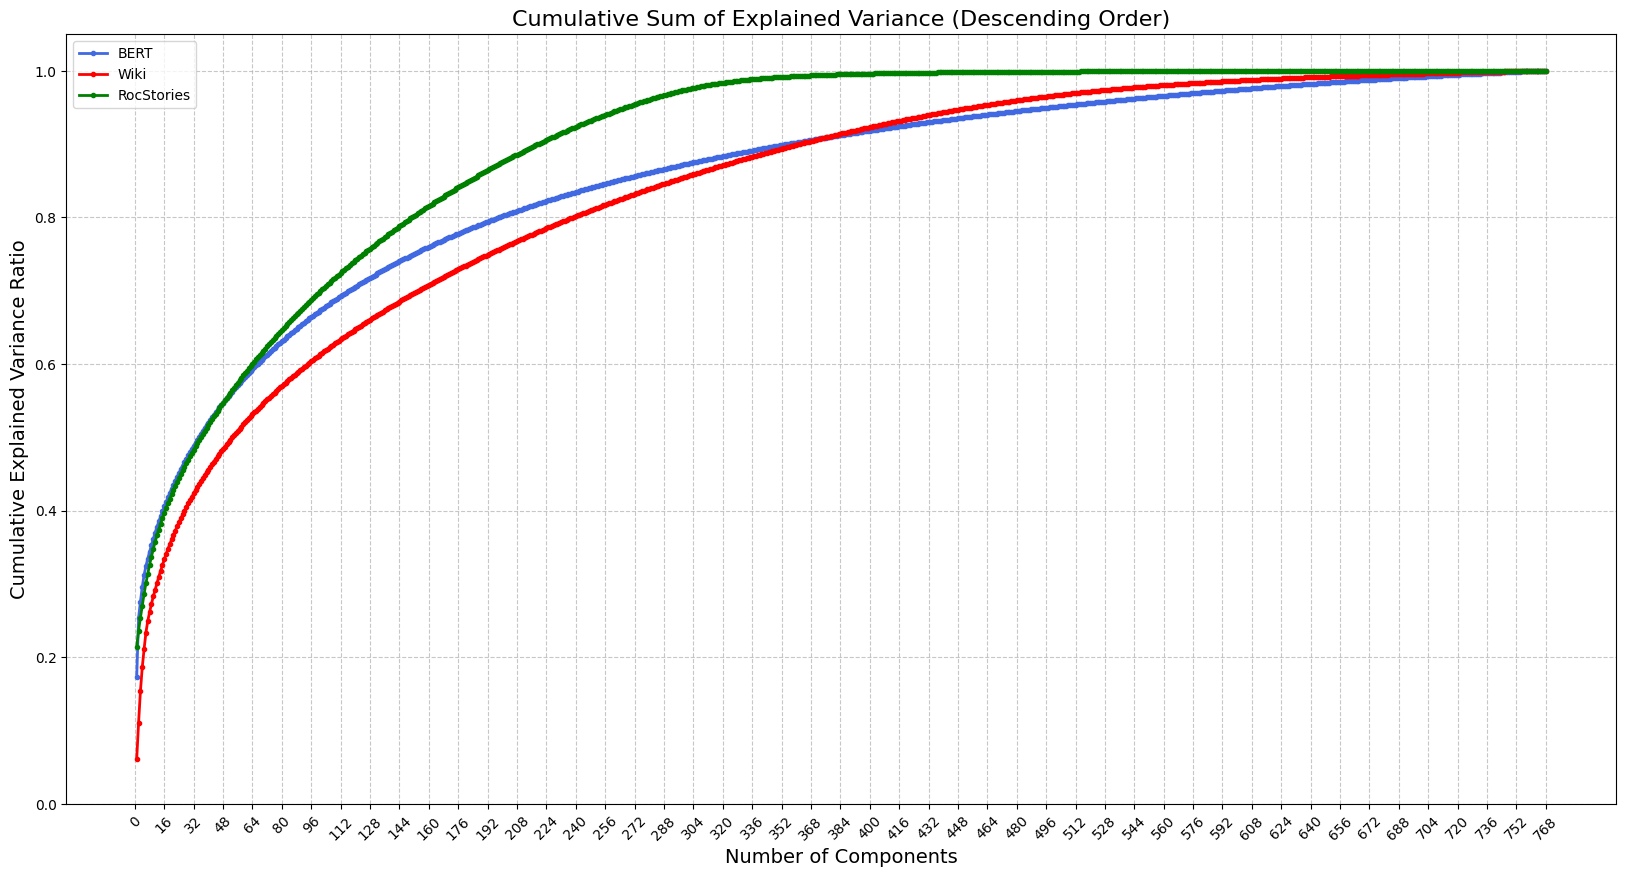

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# Compute the cumulative explained variance ratio, ensuring we start with the largest values


# Create an amazing plot
plt.figure(figsize=(20, 10))

x_range = range(1, n_components + 1)
markersize = 3

plt.plot(x_range, bert_cumulative_variance, marker='o', linestyle='-', 
         color='royalblue', linewidth=2, markersize=markersize, label='BERT')
plt.plot(x_range, wiki_cumulative_variance, marker='o', linestyle='-', 
         color='red', linewidth=2, markersize=markersize, label='Wiki')
plt.plot(x_range, roc_cumulative_variance, marker='o', linestyle='-', 
         color='green', linewidth=2, markersize=markersize, label='RocStories')
    
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Cumulative Explained Variance Ratio', fontsize=14)
plt.title('Cumulative Sum of Explained Variance (Descending Order)', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(0, n_components + 1, 16), rotation=45)
plt.ylim(0, 1.05)
plt.legend()
plt.show()

## Fourier Analysis

In [22]:
signal = bert_latent[0]

In [23]:
t = np.arange(len(signal))

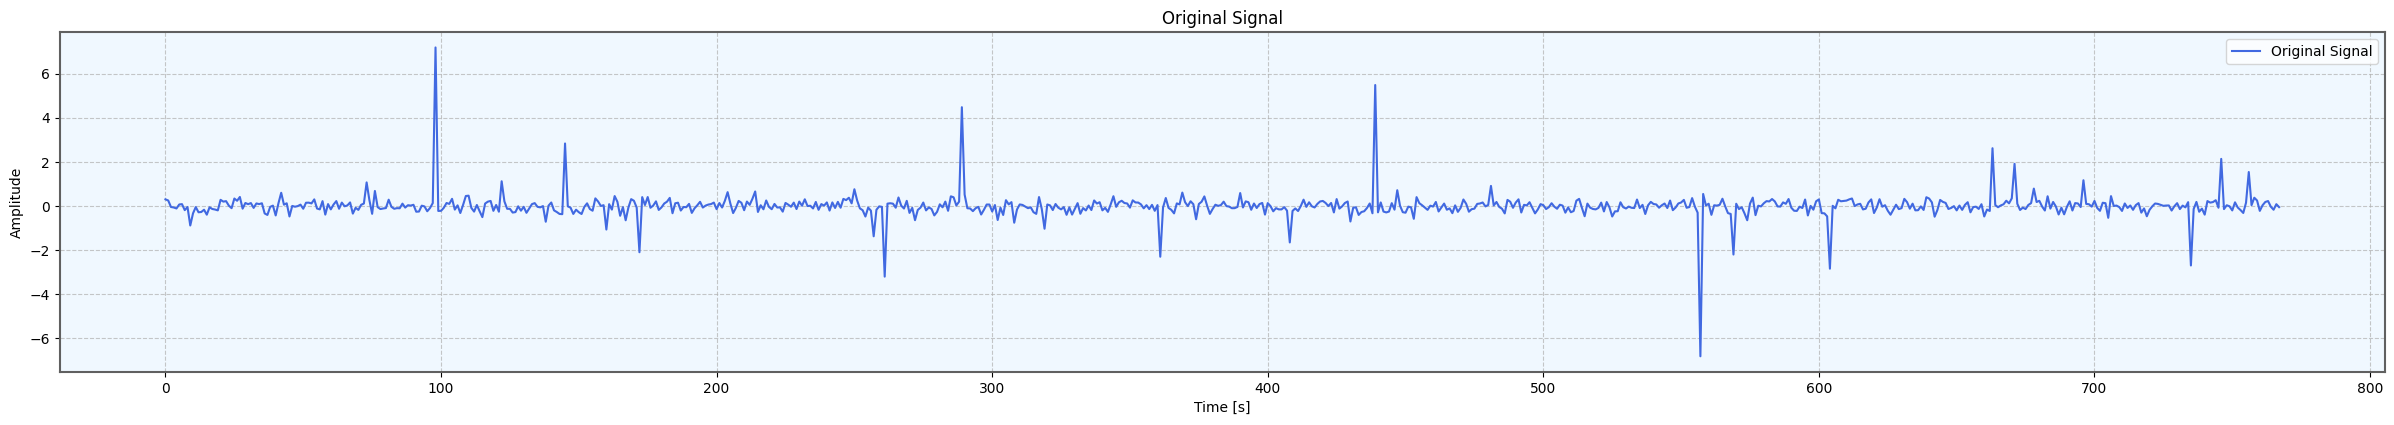

In [24]:
plt.figure(figsize=(30, 15))
ax = plt.subplot(3, 1, 1)
ax.set_facecolor('#f0f8ff')  # Set a pleasing AliceBlue background for the plot
for spine in ax.spines.values():
    spine.set_color('#606060')  # Use sleek dark gray for the subplot borders
    spine.set_linewidth(1.5)
ax.grid(True, linestyle='--', alpha=0.7)  # Add a subtle grid to enhance readability
plt.plot(t, signal, label='Original Signal', color='royalblue')
plt.title('Original Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()

In [25]:
fs = 1024

# 2. Fourier Decomposition (FFT)
fft_signal = np.fft.fft(signal)              # Compute the FFT of the signal
frequencies = np.fft.fftfreq(len(signal), d=1/fs)  # Frequency bins

In [26]:
def remove_freqs(signal, cutoff=10):
    fft_signal = np.fft.fft(signal)              # Compute the FFT of the signal
    frequencies = np.fft.fftfreq(len(signal), d=1/fs)
    fft_filtered = fft_signal.copy()  # Create a copy of the FFT data

    fft_filtered[np.abs(frequencies) > cutoff] = 0
    filtered_signal = np.fft.ifft(fft_filtered)
    return filtered_signal.real


In [27]:
filtered_signal = remove_freqs(signal, 768 // 4)

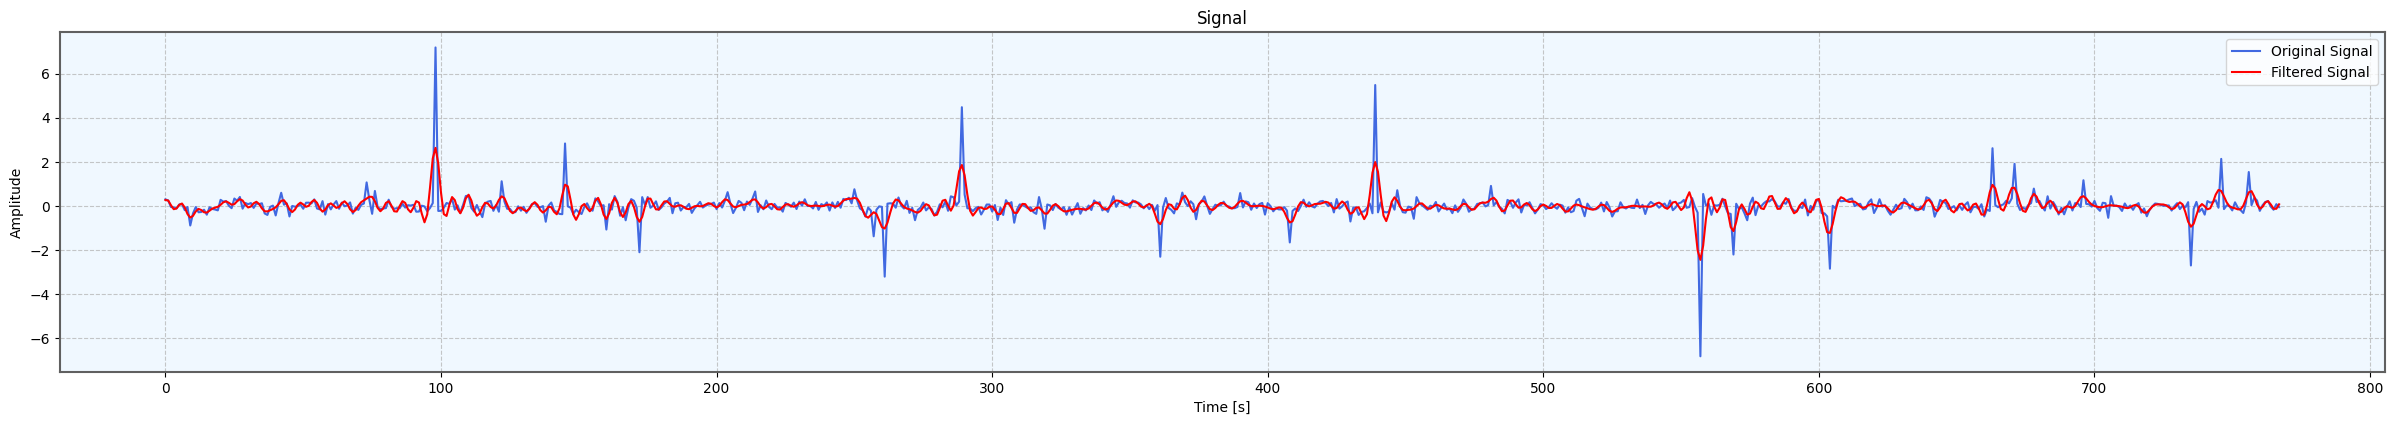

In [28]:
plt.figure(figsize=(30, 15))
ax = plt.subplot(3, 1, 1)
ax.set_facecolor('#f0f8ff')  # Set a pleasing AliceBlue background for the plot
for spine in ax.spines.values():
    spine.set_color('#606060')  # Use sleek dark gray for the subplot borders
    spine.set_linewidth(1.5)
ax.grid(True, linestyle='--', alpha=0.7)  # Add a subtle grid to enhance readability

plt.plot(t, signal, label='Original Signal', color='royalblue')
plt.plot(t, filtered_signal, label='Filtered Signal', color='red')

plt.title('Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()

## Wavelet Analysis

In [15]:
def wavelet_downsampling(signal, wavelet='db4', max_level=5):
    import pywt
    import numpy as np

    coeffs = pywt.wavedec(signal, wavelet, level=max_level)
    indexes_to_remove = [max_level]
    coeffs_modified = coeffs.copy()
    for index in indexes_to_remove:
        coeffs_modified[index] = np.zeros_like(coeffs_modified[index])
    reconstructed_signal = pywt.waverec(coeffs_modified, wavelet)
    return reconstructed_signal

In [81]:
wavelet_filtered_signal = wavelet_downsampling(signal, wavelet='db4', max_level=5)
filtered_signal = remove_freqs(signal, 768 // 8)

print(wavelet_filtered_signal[:10])

[ 0.16345513  0.0731709   0.02474208  0.03490011  0.02288346  0.01228229
 -0.03276999 -0.12441388 -0.22720194 -0.35339347]


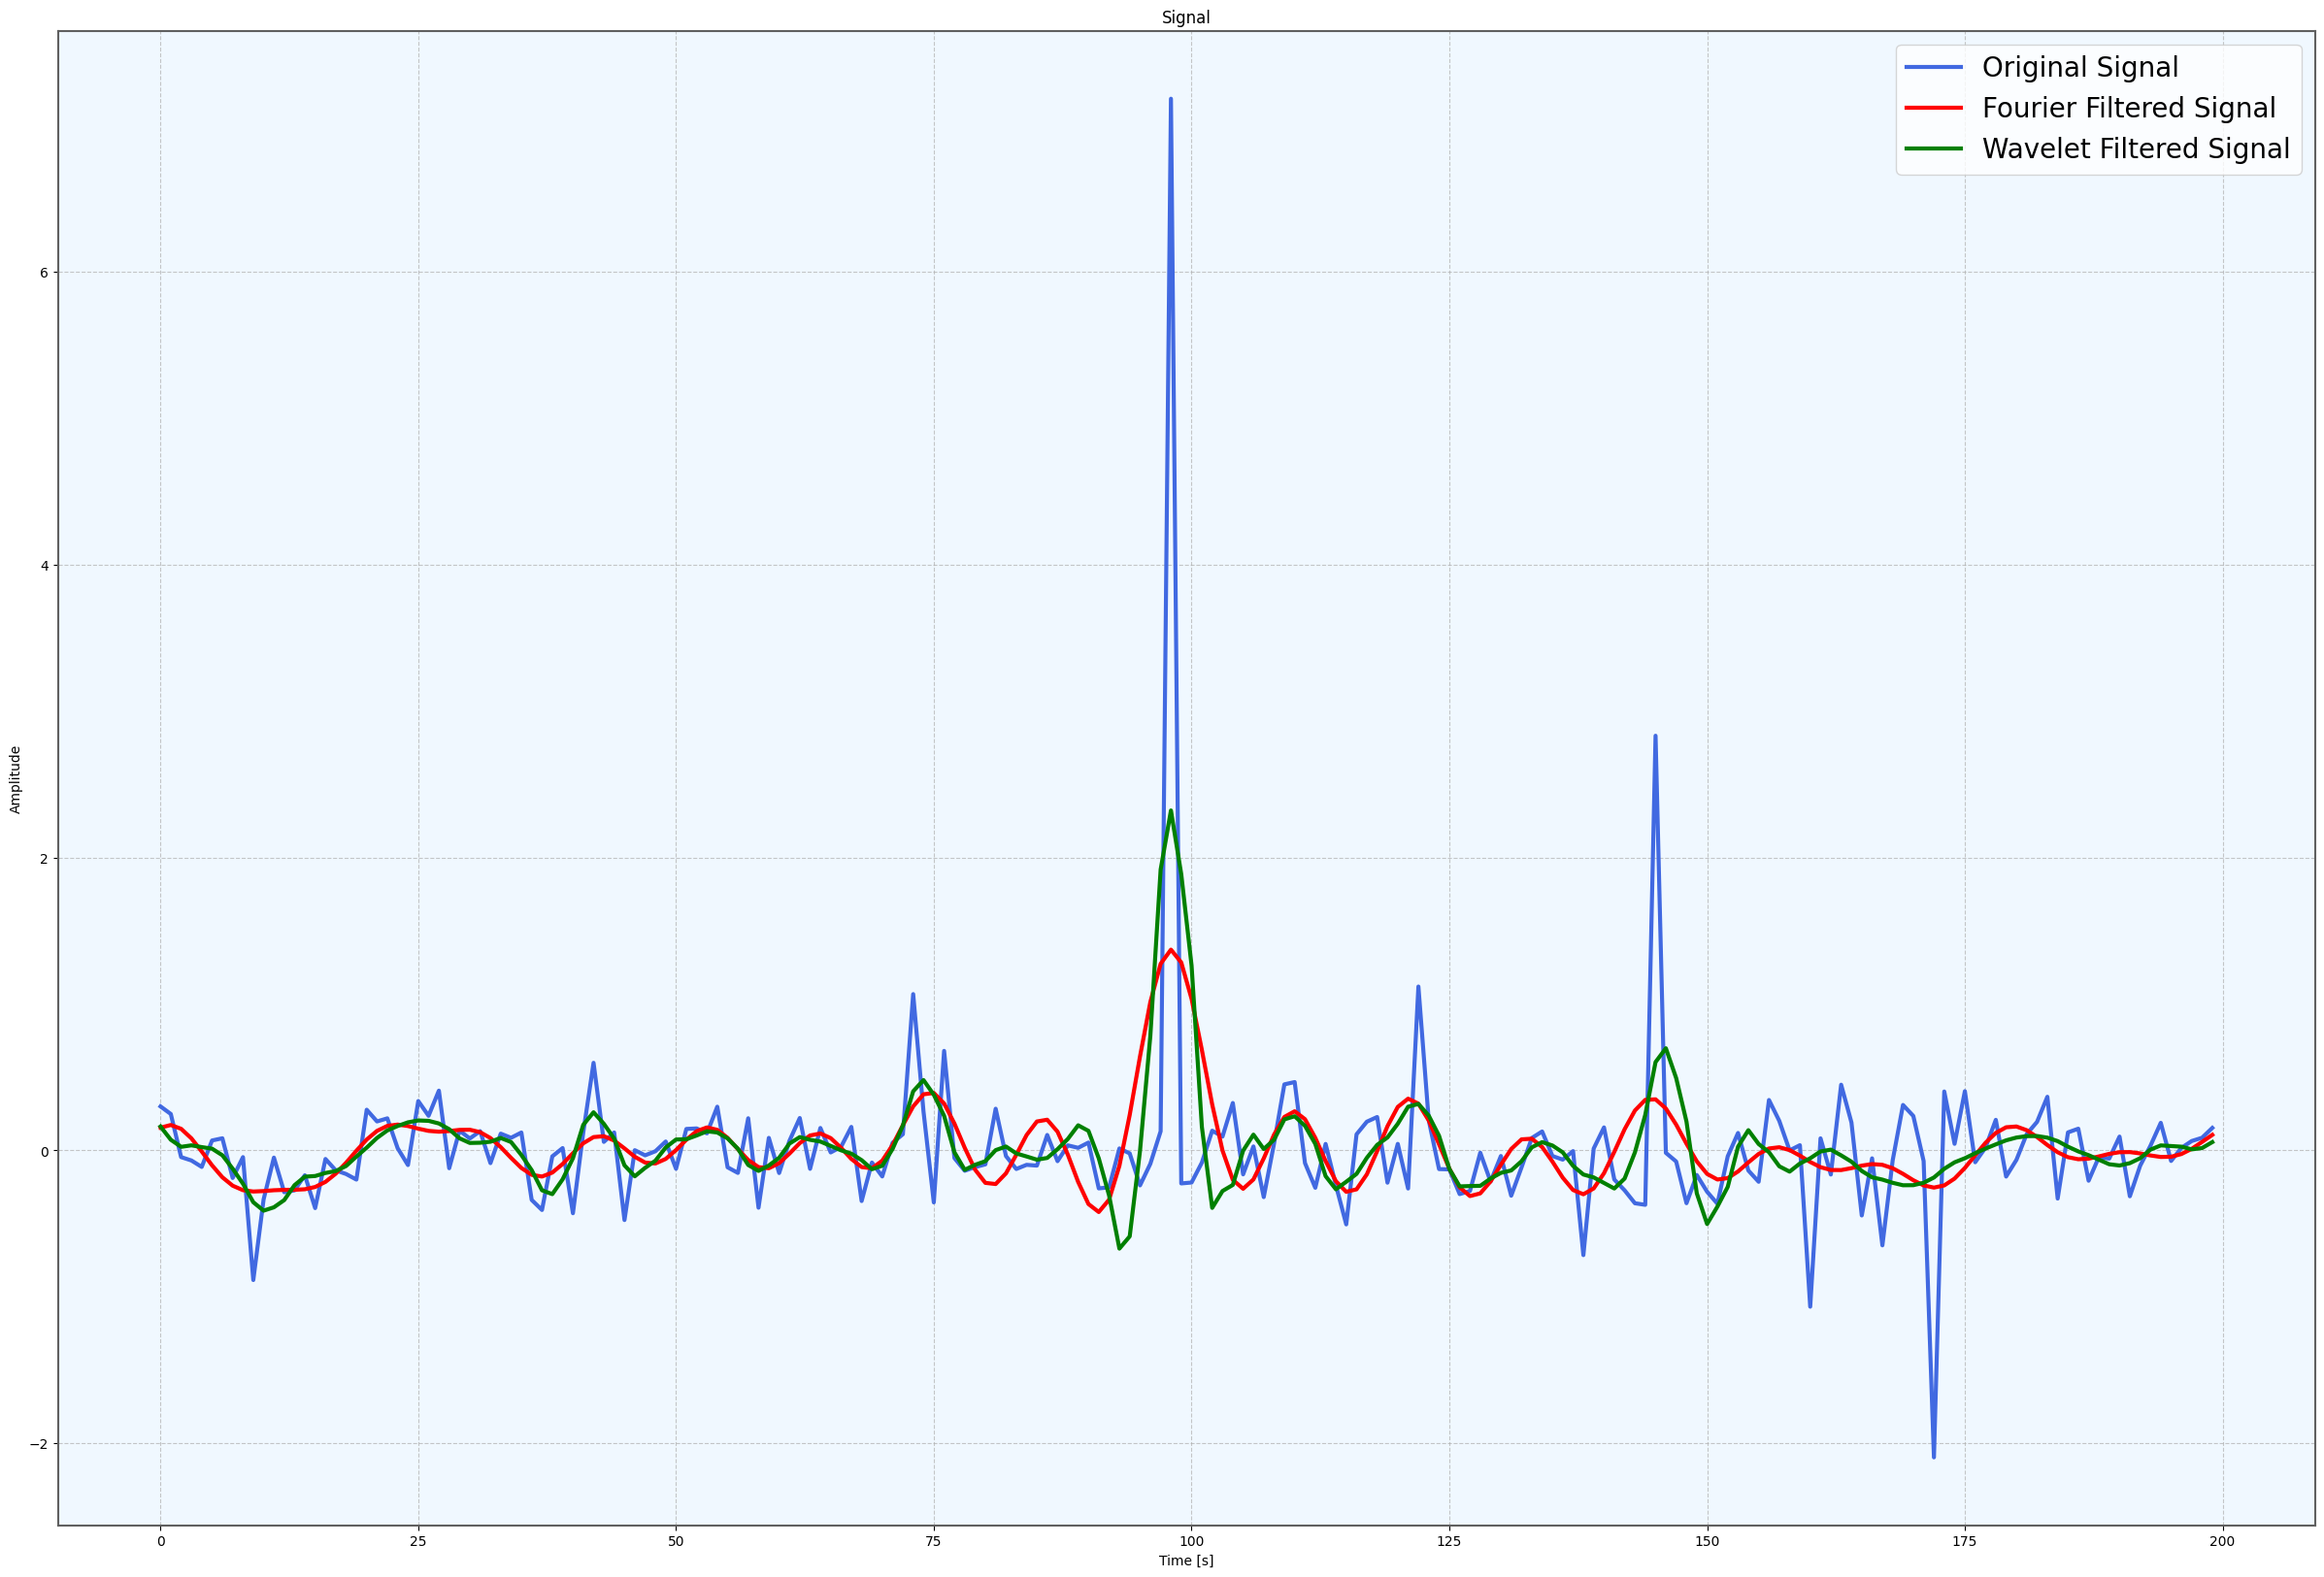

In [82]:
leave_components = 200

plt.figure(figsize=(30, 20))
ax = plt.subplot(1, 1, 1)
ax.set_facecolor('#f0f8ff')  # Set a pleasing AliceBlue background for the plot
for spine in ax.spines.values():
    spine.set_color('#606060')  # Use sleek dark gray for the subplot borders
    spine.set_linewidth(1.5)
ax.grid(True, linestyle='--', alpha=0.7)  # Add a subtle grid to enhance readability

linewidth = 3
plt.plot(t[:leave_components], signal[:leave_components], label='Original Signal', color='royalblue', linewidth=linewidth)
plt.plot(t[:leave_components], filtered_signal[:leave_components], label='Fourier Filtered Signal', color='red', linewidth=linewidth)
plt.plot(t[:leave_components], wavelet_filtered_signal[:leave_components], label='Wavelet Filtered Signal', color='green', linewidth=linewidth)

plt.title('Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend(fontsize=20)

In [96]:
def energy_analysis(signal, wavelet='db4', max_level=1):
    import pywt
    import numpy as np

    coeffs = pywt.wavedec(signal, wavelet, level=max_level)
    energy = np.sum(np.square(coeffs[-1]), axis=1)
    return energy

In [105]:
energy_bert = energy_analysis(bert_latent, max_level=2)
energy_wiki = energy_analysis(latents_wiki_16.reshape(-1, n_components).cpu().numpy(), max_level=2)
energy_roc = energy_analysis(latents_roc_16.reshape(-1, n_components).cpu().numpy(), max_level=2)


In [106]:
energy_roc = energy_roc[energy_roc < 420]

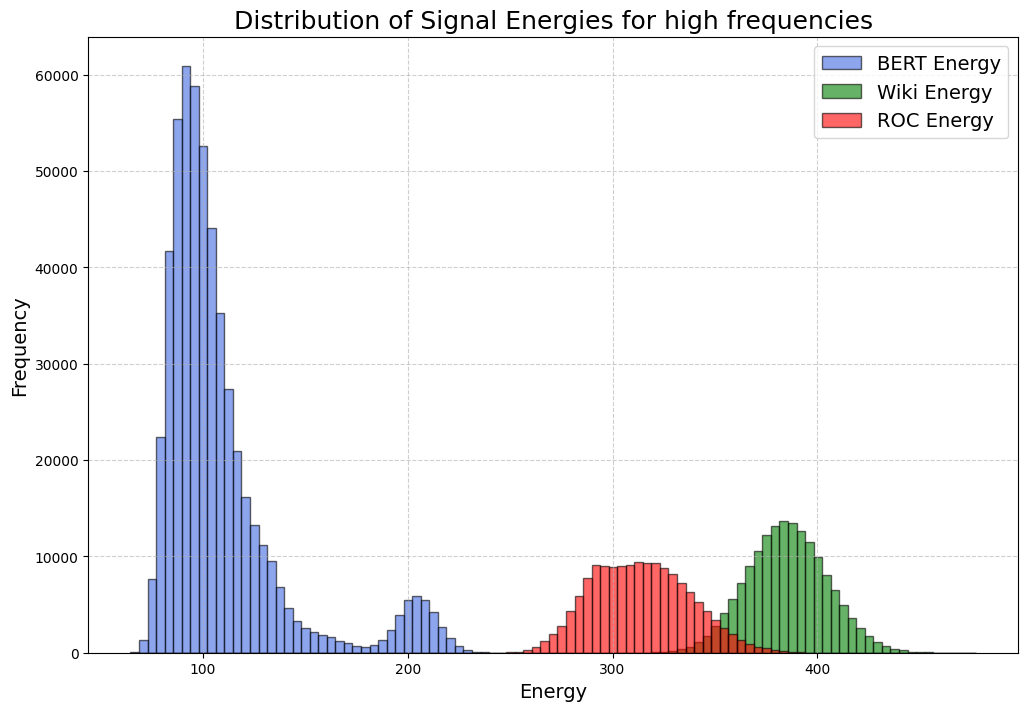

In [107]:
plt.figure(figsize=(12, 8))

num_bins = 100
range_max = np.max([np.max(energy_bert), np.max(energy_wiki), np.max(energy_roc)])
range_min = np.min([np.min(energy_bert), np.min(energy_wiki), np.min(energy_roc)])
bins = np.linspace(range_min, range_max, num_bins)

plt.hist(energy_bert, bins=bins, alpha=0.6, label='BERT Energy', color='royalblue', edgecolor='k')
plt.hist(energy_wiki, bins=bins, alpha=0.6, label='Wiki Energy', color='green', edgecolor='k')
plt.hist(energy_roc, bins=bins, alpha=0.6, label='ROC Energy', color='red', edgecolor='k')
plt.xlabel('Energy', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Signal Energies for high frequencies', fontsize=18)
plt.legend(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


### Reconstruction for wavelet downsampling

In [16]:
from tqdm import tqdm

def get_logits_from_latent(latent, trainer):
    batch_size = 100
    num_samples = latent.shape[0]
    total_logits = torch.zeros((num_samples, trainer.decoder.max_position_embeddings, trainer.decoder.vocab_size), device="cpu")

    for i in range(0, num_samples, batch_size):
        batch_i = latent[i:i+batch_size]
        with torch.autocast(device_type='cuda', dtype=torch.bfloat16), torch.no_grad():
            logits = trainer.decoder(batch_i)
        total_logits[i:i+batch_size] = logits.cpu()
    return total_logits

In [38]:
def masked_accuracy(tokens, tokenized_X, num_samples):
    mask = tokenized_X["attention_mask"][:num_samples].bool()
    print(tokens[mask].shape, tokenized_X["input_ids"][:num_samples][mask].shape)
    return (tokens[mask] == tokenized_X["input_ids"][:num_samples][mask]).float().mean()

In [36]:
num_samples = 10
n_components = 768

signal = latents_roc_16[:num_samples].reshape(-1, n_components).cpu().numpy()
wavelet_filtered_signal = wavelet_downsampling(signal, wavelet='db4', max_level=2)
wavelet_filtered_signal = wavelet_filtered_signal.reshape(num_samples, -1, n_components)

In [40]:
filtered_latent = torch.from_numpy(wavelet_filtered_signal).to(device)
logits = get_logits_from_latent(filtered_latent, trainer_roc_16).argmax(dim=2)

acc = masked_accuracy(logits, tokenized.to("cpu"), num_samples)

torch.Size([538]) torch.Size([538])


/home/jovyan/.mlspace/envs/dif_env_v2/lib/python3.11/contextlib.py:105: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


In [42]:
acc

tensor(0.9572)

# Space Analysis

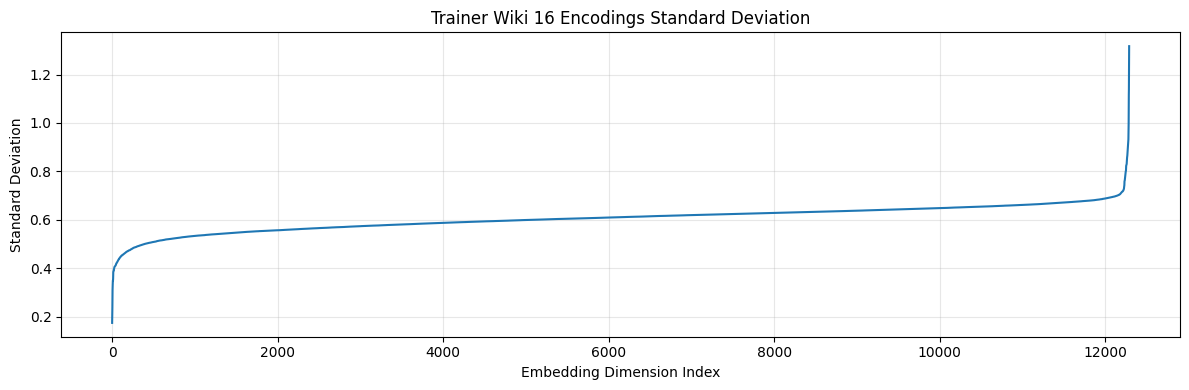

In [30]:
trainer_wiki_16.encodings_std

import matplotlib.pyplot as plt

# Convert to NumPy for plotting
std_values = torch.sort(trainer_wiki_16.latent_std.flatten())[0].detach().cpu().numpy()

plt.figure(figsize=(12, 4))
plt.plot(std_values, lw=1.5)
plt.title("Trainer Wiki 16 Encodings Standard Deviation")
plt.xlabel("Embedding Dimension Index")
plt.ylabel("Standard Deviation")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


NameError: name 'image' is not defined